In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import cv2
import numpy as np 
import pandas as pd 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input

In [2]:
train_df = pd.read_csv('/kaggle/input/dog-breed-identification/labels.csv')
test_df=pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')
train_file = '/kaggle/input/dog-breed-identification/train/'
test_file = '/kaggle/input/dog-breed-identification/test/'

In [ ]:
train_df

In [ ]:
print("Total number of unique Dog Breeds :",len(train_df.breed.unique()))

In [3]:
num_breeds = 120
im_size = 224
batch_size = 64
encoder = LabelEncoder()

In [4]:
train_df['img_file']=train_df['id']+'.jpg'
test_df['img_file']=test_df['id']+'.jpg'

In [5]:
X = train_df['img_file']
y = train_df['breed']

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
train_file = "/kaggle/input/dog-breed-identification/train/"
sub_class = os.listdir(train_file)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(train_file,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
test_file = "/kaggle/input/dog-breed-identification/test/"
sub_class = os.listdir(test_file)

fig = plt.figure(figsize=(10,5))
for e in range(len(sub_class[:8])):
    plt.subplot(2,4,e+1)
    img = plt.imread(os.path.join(test_file,sub_class[e]))
    plt.imshow(img, cmap=plt.get_cmap('gray'))

In [ ]:
plt.figure(figsize=(13, 6))
y.value_counts().plot(kind='bar')
plt.show()

In [6]:
train_x = np.zeros((len(train_df), im_size, im_size, 3), dtype='float32')

In [7]:
for i, img_id in enumerate(X):
    img = cv2.resize(cv2.imread(train_file+img_id,cv2.IMREAD_COLOR),((im_size,im_size)))
    img_array = preprocess_input(np.expand_dims(np.array(img[...,::-1].astype(np.float32)).copy(), axis=0))
    train_x[i] = img_array

In [8]:
train_y = encoder.fit_transform(train_df["breed"].values)

In [ ]:
train_x.shape

In [ ]:
train_y.shape

In [9]:
X_train, X_test, y_train, y_test = train_test_split(train_x,train_y,test_size=0.2,shuffle=True,random_state=42)

In [10]:
train_datagen = ImageDataGenerator(
        rescale=1 / 255.0,
        rotation_range=20,
        zoom_range=0.05,
        width_shift_range=0.05,
        height_shift_range=0.05,
        shear_range=0.05,
        horizontal_flip=True,
        fill_mode="nearest",
        validation_split=0.2)

In [11]:
train_generator = train_datagen.flow_from_dataframe( 
                        dataframe=train_df,
                        directory=train_file,
                        x_col='img_file',
                        y_col='breed',
                        subset="training",
                        batch_size=batch_size,
                        seed=42,
                        shuffle=True,
                        target_size=(224,224),
                        class_mode="categorical"
                        )    
     
validation_generator = train_datagen.flow_from_dataframe(
                        dataframe=train_df,
                        directory=train_file,
                        x_col='img_file',
                        y_col='breed',
                        subset="validation",
                        batch_size=batch_size,
                        seed=None,
                        shuffle=True,
                        target_size=(224,224),
                        class_mode="categorical"
                        )

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [12]:
from tensorflow.keras.callbacks import EarlyStopping


custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=3, 
    min_delta=0.001, 
    mode='max'
)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,   
    patience=2, 
    min_lr=0.001,
    verbose=2
)

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def plot_metric(hist, metric):
    train_metrics = hist.history[metric]
    val_metrics = hist.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [15]:
X_train.shape

(8177, 224, 224, 3)

In [16]:
y_train.shape

(8177,)

In [ ]:
X_test.shape

In [ ]:
y_test.shape

In [ ]:
train_generator.class_indices.keys()

In [ ]:
validation_generator.class_indices.keys()

In [17]:
test_datagen=ImageDataGenerator(rescale=1 /255.0)

test_generator=test_datagen.flow_from_dataframe(
                            dataframe=test_df,
                            directory='/kaggle/input/dog-breed-identification/test',
                            x_col="img_file",
                            y_col=None,
                            batch_size=1,
                            seed=42,
                            shuffle=False,
                            class_mode=None,
                            target_size=(224,224))

Found 10357 validated image filenames.


In [ ]:
del model

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


In [18]:
resnet = ResNet50V2(input_shape = [im_size,im_size,3], weights='imagenet', include_top=False)
for layer in resnet.layers:
    layer.trainable = False
x = resnet.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

2023-02-08 06:46:39.568347: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


94683136/94668760 [==============================] - 1s 0us/step


In [19]:
predictions = Dense(num_breeds, activation='softmax')(x)
 
model = Model(inputs=resnet.input, outputs=predictions)
#model.summary()

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model)

In [ ]:
!pip install tensorflow

In [ ]:
!pip freeze | grep tensorflow

In [ ]:
import tensorflow as tf

# Create a summary writer
writer = tf.summary.create_file_writer("logs")

# Write data to the summary writer
with writer.as_default():
    tf.summary.scalar("loss", 0.5, step=0)

# Start TensorBoard
%tensorboard --logdir logs



In [ ]:
%load_ext tensorboard


In [ ]:
%reload_ext tensorboard

In [ ]:
import os,datetime


In [ ]:
tf_callback=tf.keras.callbacks.TensorBoard(log_dir='logs',histogram_freq=1)

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint_path = 'model_checkpoints/'
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq='epoch',
    save_weights_only=True,
    verbose=1
)

In [21]:
from tensorflow.keras.callbacks import CSVLogger
csv_log = CSVLogger("results.csv")


In [23]:
import os

In [24]:
epochs = 30
learning_rate = 1e-3
steps_per_epoch=train_generator.n//train_generator.batch_size
validation_steps=validation_generator.n//validation_generator.batch_size
 
optimizer = RMSprop(learning_rate=learning_rate,rho=0.9)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=["accuracy"]
             )

hist = model.fit(train_generator,
                 validation_data = validation_generator,
                 steps_per_epoch = steps_per_epoch,
                 validation_steps = validation_steps,
                 epochs=epochs,
                 callbacks=[custom_early_stopping,checkpoint,reduce_lr,csv_log]
                 )
 
model.save("resnetadammodel")

2023-02-08 06:48:14.417547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
127/127 [==============================] - 713s 6s/step - loss: 2.4174 - accuracy: 0.4200 - val_loss: 1.2550 - val_accuracy: 0.6396

Epoch 00001: saving model to model_checkpoints/
Epoch 2/30
127/127 [==============================] - 704s 6s/step - loss: 1.3170 - accuracy: 0.6228 - val_loss: 1.1342 - val_accuracy: 0.6618

Epoch 00002: saving model to model_checkpoints/
Epoch 3/30
127/127 [==============================] - 704s 6s/step - loss: 1.1541 - accuracy: 0.6658 - val_loss: 1.1489 - val_accuracy: 0.6593

Epoch 00003: saving model to model_checkpoints/
Epoch 4/30
127/127 [==============================] - 703s 6s/step - loss: 1.0505 - accuracy: 0.6920 - val_loss: 1.1689 - val_accuracy: 0.6719

Epoch 00004: saving model to model_checkpoints/
Epoch 5/30
127/127 [==============================] - 706s 6s/step - loss: 0.9602 - accuracy: 0.7186 - val_loss: 1.1756 - val_accuracy: 0.6673

Epoch 00005: saving model to model_checkpoints/
Epoch 6/30
127/127 [====================

2023-02-08 08:37:53.845954: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [25]:
import pandas as pd
pd.read_csv("results.csv", index_col='epoch')

,accuracy,loss,lr,val_accuracy,val_loss
epoch,,,,,
0,0.420015,2.417382,0.001,0.639617,1.255043
1,0.622751,1.317035,0.001,0.661794,1.134231
2,0.665763,1.154127,0.001,0.659274,1.148902
3,0.692014,1.050460,0.001,0.671875,1.168914
4,0.718634,0.960191,0.001,0.667339,1.175579
5,0.730096,0.903394,0.001,0.680444,1.167400
6,0.749815,0.837431,0.001,0.671875,1.181803
7,0.751664,0.828324,0.001,0.671875,1.191697
8,0.767809,0.768886,0.001,0.671875,1.257953


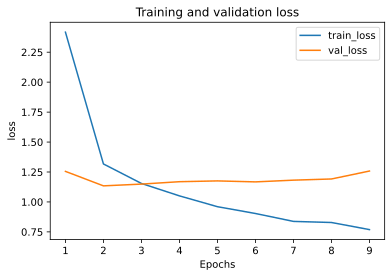

In [26]:
import matplotlib.pyplot as plt
plot_metric(hist,'loss')

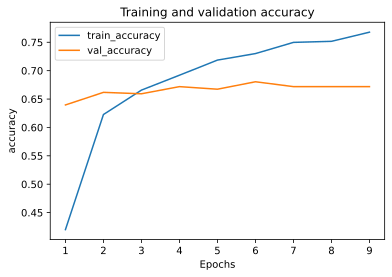

In [27]:
plot_metric(hist,'accuracy')

In [28]:
def plot_lr(hist):
    learning_rate = hist.history['lr']
    epochs = range(1, len(learning_rate) + 1)
    plt.plot(epochs, learning_rate)
    plt.title('Learning rate')
    plt.xlabel('Epochs')
    plt.ylabel('Learning rate')
    plt.show()

In [29]:
def get_test_accuracy(model, X_test, y_test):
    test_loss, test_acc = model.evaluate(x=X_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [ ]:
get_test_accuracy(model, X_test, y_test)

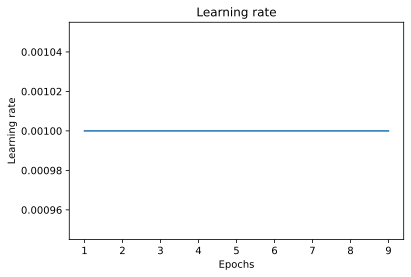

In [31]:
plot_lr(hist)

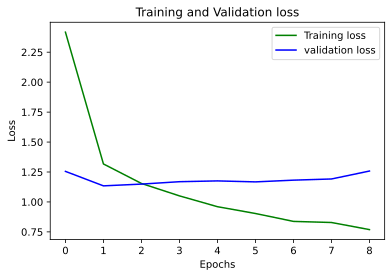

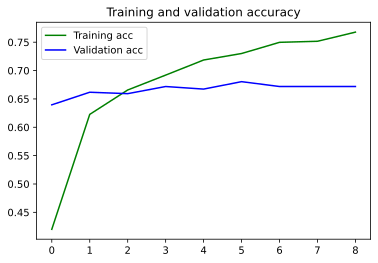

<Figure size 432x288 with 0 Axes>

In [32]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss_train = hist.history['loss']
loss_val = hist.history['val_loss']
epochs = range(len(loss_train))
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.figure()

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.show()

In [33]:
score = model.evaluate(validation_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

32/32 [==============================] - 142s 4s/step - loss: 1.2189 - accuracy: 0.6781
Test loss: 1.2188756465911865
Test accuracy: 0.6780821681022644


In [34]:
print("Evaluate")
result = model.evaluate(test_generator)
dict(zip(model.metrics_names, result))

Evaluate
10357/10357 [==============================] - 126s 12ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


{'loss': 0.0, 'accuracy': 0.0}

In [35]:
import os
test_images = os.listdir('/kaggle/input/dog-breed-identification/test/')
test_set = pd.DataFrame(test_images, columns=['img_file'])
test_set.head(10)

,img_file
0,09e51e17e2b756ff2ace8a87bd1443fa.jpg
1,f7a32505c12649183c5991ecfa7d68b3.jpg
2,bc6d50ffb4644feb34530aa58943e85b.jpg
3,7cbc041e79135a572aad87904b5c9c57.jpg
4,f3b603f10d6a344f0395fb46b242ff8e.jpg
5,db55098d859d27a3c05b0e3fc41d43e7.jpg
6,665bab06a3ea861c0812c778486988e3.jpg
7,7b57911ea7559cebd6db308125926642.jpg
8,df0d6ba158287cb2b3ed6459a22d42ba.jpg
9,b80d89ad4a17ac2537ff46d251efcd7c.jpg


In [39]:
test_generator.reset()
pred = model.predict(test_generator, steps=len(test_generator), verbose=2)

from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

y_pred = np.argmax(pred, axis=1)

x_gen,y_gen = test_generator.next()
y_gen = np.argmax(y_gen, axis=1)

print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_gen, y_pred)))

10357/10357 - 1147s


ValueError: not enough values to unpack (expected 2, got 1)

In [36]:
results = pd.DataFrame(columns=["img_file"] + [*train_generator.class_indices.keys()])
results

,img_file,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [37]:
labels = (train_generator.class_indices)

labels = list(labels.keys())

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, cohen_kappa_score

y_pred = np.argmax(pred, axis=1)
x_gen,y_gen = test_generator.next()
y_gen = np.argmax(y_gen, axis=1)

print('Confusion Matrix')
print(pd.DataFrame(confusion_matrix(y_gen, y_pred)))

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
predict=model.predict(test_generator, steps = len(test_generator.filenames))


In [ ]:
predict[:5]

In [ ]:
y_classes = predict.argmax(axis=-1)
print(y_classes)

In [ ]:
len(y_classes)

In [40]:
labels = (train_generator.class_indices)
labels = list(labels.keys())
df = pd.DataFrame(data=pred,
                 columns=labels)

columns = list(df)
columns.sort()
df = df.reindex(columns=columns)

filenames = test_df["id"]
df["id"]  = filenames
df['img_file']=df['id']+'.jpg'

cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head(5)

,img_file,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier,id
0,000621fb3cbb32d8935728e48679680e.jpg,6.032942e-07,2.394090e-09,3.015050e-10,2.909590e-13,6.037892e-11,8.600052e-12,1.492877e-10,5.484950e-12,3.418323e-11,...,9.862046e-11,1.489219e-11,8.855295e-12,3.062996e-11,3.532799e-10,2.817041e-12,3.127641e-11,3.875596e-11,2.412836e-08,000621fb3cbb32d8935728e48679680e
1,00102ee9d8eb90812350685311fe5890.jpg,5.597108e-08,1.706852e-08,1.342741e-07,3.109514e-08,4.651768e-07,7.901461e-07,1.444590e-07,3.469184e-08,1.318830e-08,...,1.812640e-07,1.041807e-08,1.169208e-07,4.663438e-08,1.982519e-08,2.298585e-06,2.600383e-07,6.802615e-08,6.974618e-09,00102ee9d8eb90812350685311fe5890
2,0012a730dfa437f5f3613fb75efcd4ce.jpg,3.943422e-10,4.525025e-06,1.011570e-09,2.599255e-07,1.406941e-08,2.362635e-07,4.658093e-10,2.016324e-10,4.455421e-07,...,2.161923e-09,1.563705e-08,4.392469e-06,1.233172e-05,1.232837e-04,4.732282e-08,4.738424e-06,1.500382e-07,4.481986e-10,0012a730dfa437f5f3613fb75efcd4ce
3,001510bc8570bbeee98c8d80c8a95ec1.jpg,1.260397e-03,2.836892e-04,3.771107e-06,1.113224e-06,4.588281e-05,1.059989e-03,5.206738e-08,5.014903e-06,8.841546e-05,...,2.368382e-08,3.111746e-06,9.943196e-07,3.476972e-05,1.636676e-05,4.323675e-07,8.960932e-05,3.250805e-09,8.015077e-06,001510bc8570bbeee98c8d80c8a95ec1
4,001a5f3114548acdefa3d4da05474c2e.jpg,8.940621e-05,2.921110e-06,1.433356e-07,8.393146e-09,1.954899e-09,4.609352e-11,3.213459e-08,2.533628e-12,6.758317e-11,...,1.261723e-12,3.918896e-11,5.064990e-11,2.623057e-10,5.387011e-10,1.041842e-08,3.314908e-09,2.563918e-09,2.766490e-06,001a5f3114548acdefa3d4da05474c2e


In [63]:
results["id"] = [os.path.splitext(file)[0] for file in os.listdir('../input/dog-breed-identification/test/')]
results.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier,id
0,6.032942e-07,2.394090e-09,3.015050e-10,2.909590e-13,6.037892e-11,8.600052e-12,1.492877e-10,5.484950e-12,3.418323e-11,2.530428e-10,...,9.862046e-11,1.489219e-11,8.855295e-12,3.062996e-11,3.532799e-10,2.817041e-12,3.127641e-11,3.875596e-11,2.412836e-08,09e51e17e2b756ff2ace8a87bd1443fa
1,5.597108e-08,1.706852e-08,1.342741e-07,3.109514e-08,4.651768e-07,7.901461e-07,1.444590e-07,3.469184e-08,1.318830e-08,4.806265e-07,...,1.812640e-07,1.041807e-08,1.169208e-07,4.663438e-08,1.982519e-08,2.298585e-06,2.600383e-07,6.802615e-08,6.974618e-09,f7a32505c12649183c5991ecfa7d68b3
2,3.943422e-10,4.525025e-06,1.011570e-09,2.599255e-07,1.406941e-08,2.362635e-07,4.658093e-10,2.016324e-10,4.455421e-07,7.896895e-08,...,2.161923e-09,1.563705e-08,4.392469e-06,1.233172e-05,1.232837e-04,4.732282e-08,4.738424e-06,1.500382e-07,4.481986e-10,bc6d50ffb4644feb34530aa58943e85b
3,1.260397e-03,2.836892e-04,3.771107e-06,1.113224e-06,4.588281e-05,1.059989e-03,5.206738e-08,5.014903e-06,8.841546e-05,1.213133e-04,...,2.368382e-08,3.111746e-06,9.943196e-07,3.476972e-05,1.636676e-05,4.323675e-07,8.960932e-05,3.250805e-09,8.015077e-06,7cbc041e79135a572aad87904b5c9c57
4,8.940621e-05,2.921110e-06,1.433356e-07,8.393146e-09,1.954899e-09,4.609352e-11,3.213459e-08,2.533628e-12,6.758317e-11,3.717236e-11,...,1.261723e-12,3.918896e-11,5.064990e-11,2.623057e-10,5.387011e-10,1.041842e-08,3.314908e-09,2.563918e-09,2.766490e-06,f3b603f10d6a344f0395fb46b242ff8e


In [42]:
y_pred = model.predict(test_generator)


In [57]:
submission=pd.read_csv('/kaggle/input/dog-breed-identification/sample_submission.csv')

In [75]:
submission.to_csv('results.csv',index=False)

In [74]:
submission=pd.read_csv('/kaggle/working/submission.csv')
submission.rename(columns={'img_file':'id'}, inplace=True)
submission

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,6.032942e-07,2.394090e-09,3.015050e-10,2.909590e-13,6.037892e-11,8.600052e-12,1.492877e-10,5.484950e-12,3.418323e-11,...,4.027266e-09,9.862046e-11,1.489219e-11,8.855295e-12,3.062996e-11,3.532799e-10,2.817041e-12,3.127641e-11,3.875596e-11,2.412836e-08
1,f7a32505c12649183c5991ecfa7d68b3,5.597108e-08,1.706852e-08,1.342741e-07,3.109514e-08,4.651768e-07,7.901461e-07,1.444590e-07,3.469184e-08,1.318830e-08,...,8.093860e-06,1.812640e-07,1.041807e-08,1.169208e-07,4.663438e-08,1.982519e-08,2.298585e-06,2.600383e-07,6.802615e-08,6.974618e-09
2,bc6d50ffb4644feb34530aa58943e85b,3.943422e-10,4.525025e-06,1.011570e-09,2.599255e-07,1.406941e-08,2.362635e-07,4.658093e-10,2.016324e-10,4.455421e-07,...,9.203922e-08,2.161923e-09,1.563705e-08,4.392469e-06,1.233172e-05,1.232837e-04,4.732282e-08,4.738424e-06,1.500382e-07,4.481986e-10
3,7cbc041e79135a572aad87904b5c9c57,1.260397e-03,2.836892e-04,3.771107e-06,1.113224e-06,4.588281e-05,1.059989e-03,5.206738e-08,5.014903e-06,8.841546e-05,...,1.117369e-05,2.368382e-08,3.111746e-06,9.943196e-07,3.476972e-05,1.636676e-05,4.323675e-07,8.960932e-05,3.250805e-09,8.015077e-06
4,f3b603f10d6a344f0395fb46b242ff8e,8.940621e-05,2.921110e-06,1.433356e-07,8.393146e-09,1.954899e-09,4.609352e-11,3.213459e-08,2.533628e-12,6.758317e-11,...,2.415673e-09,1.261723e-12,3.918896e-11,5.064990e-11,2.623057e-10,5.387011e-10,1.041842e-08,3.314908e-09,2.563918e-09,2.766490e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,d28a328d59d0b2d37fb3ae7ff0128451,4.445281e-08,9.667227e-04,4.741411e-07,3.511986e-06,2.305175e-07,1.807628e-07,4.463947e-08,6.024131e-08,6.773891e-07,...,3.758912e-03,1.246555e-07,1.980412e-07,8.908682e-07,1.236792e-05,7.509325e-06,9.147082e-08,1.011713e-05,1.016504e-05,3.137546e-08
10353,e60f6620bf8751538db9006d425f1b45,8.013989e-14,7.451827e-11,7.704461e-11,1.004351e-07,8.794670e-05,2.327136e-08,1.040532e-11,5.877759e-07,9.822052e-07,...,3.341383e-11,6.339627e-09,3.817277e-06,1.369902e-07,9.991591e-01,2.367330e-08,1.199300e-11,1.431040e-05,2.934713e-09,1.570514e-10
10354,54f6834b3819d6f0e9ff966070f35668,2.657578e-08,7.710782e-08,2.024039e-05,5.462955e-09,2.799949e-06,1.591379e-06,6.506954e-08,1.074517e-04,2.881090e-07,...,7.187555e-08,1.062678e-06,1.573253e-05,2.136773e-07,2.913379e-07,1.250902e-06,9.609681e-09,4.827400e-05,3.238900e-08,3.467444e-08
10355,0608afccc6d9b117730a2ffdb3314d18,4.378373e-06,7.479534e-09,5.857616e-11,1.720230e-11,7.346309e-12,1.530933e-11,3.840570e-09,4.059910e-13,3.696791e-11,...,1.760120e-07,4.602030e-11,7.490655e-13,1.835916e-13,3.722603e-11,3.572287e-10,1.075667e-07,3.845682e-11,6.288146e-10,5.224745e-07


In [67]:
res1=pd.read_csv('/kaggle/working/submission.csv')
res1

,img_file,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,6.032942e-07,2.394090e-09,3.015050e-10,2.909590e-13,6.037892e-11,8.600052e-12,1.492877e-10,5.484950e-12,3.418323e-11,...,4.027266e-09,9.862046e-11,1.489219e-11,8.855295e-12,3.062996e-11,3.532799e-10,2.817041e-12,3.127641e-11,3.875596e-11,2.412836e-08
1,f7a32505c12649183c5991ecfa7d68b3,5.597108e-08,1.706852e-08,1.342741e-07,3.109514e-08,4.651768e-07,7.901461e-07,1.444590e-07,3.469184e-08,1.318830e-08,...,8.093860e-06,1.812640e-07,1.041807e-08,1.169208e-07,4.663438e-08,1.982519e-08,2.298585e-06,2.600383e-07,6.802615e-08,6.974618e-09
2,bc6d50ffb4644feb34530aa58943e85b,3.943422e-10,4.525025e-06,1.011570e-09,2.599255e-07,1.406941e-08,2.362635e-07,4.658093e-10,2.016324e-10,4.455421e-07,...,9.203922e-08,2.161923e-09,1.563705e-08,4.392469e-06,1.233172e-05,1.232837e-04,4.732282e-08,4.738424e-06,1.500382e-07,4.481986e-10
3,7cbc041e79135a572aad87904b5c9c57,1.260397e-03,2.836892e-04,3.771107e-06,1.113224e-06,4.588281e-05,1.059989e-03,5.206738e-08,5.014903e-06,8.841546e-05,...,1.117369e-05,2.368382e-08,3.111746e-06,9.943196e-07,3.476972e-05,1.636676e-05,4.323675e-07,8.960932e-05,3.250805e-09,8.015077e-06
4,f3b603f10d6a344f0395fb46b242ff8e,8.940621e-05,2.921110e-06,1.433356e-07,8.393146e-09,1.954899e-09,4.609352e-11,3.213459e-08,2.533628e-12,6.758317e-11,...,2.415673e-09,1.261723e-12,3.918896e-11,5.064990e-11,2.623057e-10,5.387011e-10,1.041842e-08,3.314908e-09,2.563918e-09,2.766490e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,d28a328d59d0b2d37fb3ae7ff0128451,4.445281e-08,9.667227e-04,4.741411e-07,3.511986e-06,2.305175e-07,1.807628e-07,4.463947e-08,6.024131e-08,6.773891e-07,...,3.758912e-03,1.246555e-07,1.980412e-07,8.908682e-07,1.236792e-05,7.509325e-06,9.147082e-08,1.011713e-05,1.016504e-05,3.137546e-08
10353,e60f6620bf8751538db9006d425f1b45,8.013989e-14,7.451827e-11,7.704461e-11,1.004351e-07,8.794670e-05,2.327136e-08,1.040532e-11,5.877759e-07,9.822052e-07,...,3.341383e-11,6.339627e-09,3.817277e-06,1.369902e-07,9.991591e-01,2.367330e-08,1.199300e-11,1.431040e-05,2.934713e-09,1.570514e-10
10354,54f6834b3819d6f0e9ff966070f35668,2.657578e-08,7.710782e-08,2.024039e-05,5.462955e-09,2.799949e-06,1.591379e-06,6.506954e-08,1.074517e-04,2.881090e-07,...,7.187555e-08,1.062678e-06,1.573253e-05,2.136773e-07,2.913379e-07,1.250902e-06,9.609681e-09,4.827400e-05,3.238900e-08,3.467444e-08
10355,0608afccc6d9b117730a2ffdb3314d18,4.378373e-06,7.479534e-09,5.857616e-11,1.720230e-11,7.346309e-12,1.530933e-11,3.840570e-09,4.059910e-13,3.696791e-11,...,1.760120e-07,4.602030e-11,7.490655e-13,1.835916e-13,3.722603e-11,3.572287e-10,1.075667e-07,3.845682e-11,6.288146e-10,5.224745e-07


In [56]:
results[[*train_generator.class_indices.keys()]] = y_pred
results.head()

results.to_csv("sample_submission.csv",index=False)

ValueError: Columns must be same length as key

In [51]:
results.to_csv("submission.csv",index=False)

In [54]:
res=pd.read_csv('submission.csv')

In [45]:
res=pd.read_csv('/kaggle/working/results.csv')

In [46]:
res

,img_file,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,6.032942e-07,2.394090e-09,3.015050e-10,2.909590e-13,6.037892e-11,8.600052e-12,1.492877e-10,5.484950e-12,3.418323e-11,...,4.027266e-09,9.862046e-11,1.489219e-11,8.855295e-12,3.062996e-11,3.532799e-10,2.817041e-12,3.127641e-11,3.875596e-11,2.412836e-08
1,f7a32505c12649183c5991ecfa7d68b3,5.597108e-08,1.706852e-08,1.342741e-07,3.109514e-08,4.651768e-07,7.901461e-07,1.444590e-07,3.469184e-08,1.318830e-08,...,8.093860e-06,1.812640e-07,1.041807e-08,1.169208e-07,4.663438e-08,1.982519e-08,2.298585e-06,2.600383e-07,6.802615e-08,6.974618e-09
2,bc6d50ffb4644feb34530aa58943e85b,3.943422e-10,4.525025e-06,1.011570e-09,2.599255e-07,1.406941e-08,2.362635e-07,4.658093e-10,2.016324e-10,4.455421e-07,...,9.203922e-08,2.161923e-09,1.563705e-08,4.392469e-06,1.233172e-05,1.232837e-04,4.732282e-08,4.738424e-06,1.500382e-07,4.481986e-10
3,7cbc041e79135a572aad87904b5c9c57,1.260397e-03,2.836892e-04,3.771107e-06,1.113224e-06,4.588281e-05,1.059989e-03,5.206738e-08,5.014903e-06,8.841546e-05,...,1.117369e-05,2.368382e-08,3.111746e-06,9.943196e-07,3.476972e-05,1.636676e-05,4.323675e-07,8.960932e-05,3.250805e-09,8.015077e-06
4,f3b603f10d6a344f0395fb46b242ff8e,8.940621e-05,2.921110e-06,1.433356e-07,8.393146e-09,1.954899e-09,4.609352e-11,3.213459e-08,2.533628e-12,6.758317e-11,...,2.415673e-09,1.261723e-12,3.918896e-11,5.064990e-11,2.623057e-10,5.387011e-10,1.041842e-08,3.314908e-09,2.563918e-09,2.766490e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10352,d28a328d59d0b2d37fb3ae7ff0128451,4.445281e-08,9.667227e-04,4.741411e-07,3.511986e-06,2.305175e-07,1.807628e-07,4.463947e-08,6.024131e-08,6.773891e-07,...,3.758912e-03,1.246555e-07,1.980412e-07,8.908682e-07,1.236792e-05,7.509325e-06,9.147082e-08,1.011713e-05,1.016504e-05,3.137546e-08
10353,e60f6620bf8751538db9006d425f1b45,8.013989e-14,7.451827e-11,7.704461e-11,1.004351e-07,8.794670e-05,2.327136e-08,1.040532e-11,5.877759e-07,9.822052e-07,...,3.341383e-11,6.339627e-09,3.817277e-06,1.369902e-07,9.991591e-01,2.367330e-08,1.199300e-11,1.431040e-05,2.934713e-09,1.570514e-10
10354,54f6834b3819d6f0e9ff966070f35668,2.657578e-08,7.710782e-08,2.024039e-05,5.462955e-09,2.799949e-06,1.591379e-06,6.506954e-08,1.074517e-04,2.881090e-07,...,7.187555e-08,1.062678e-06,1.573253e-05,2.136773e-07,2.913379e-07,1.250902e-06,9.609681e-09,4.827400e-05,3.238900e-08,3.467444e-08
10355,0608afccc6d9b117730a2ffdb3314d18,4.378373e-06,7.479534e-09,5.857616e-11,1.720230e-11,7.346309e-12,1.530933e-11,3.840570e-09,4.059910e-13,3.696791e-11,...,1.760120e-07,4.602030e-11,7.490655e-13,1.835916e-13,3.722603e-11,3.572287e-10,1.075667e-07,3.845682e-11,6.288146e-10,5.224745e-07


In [ ]:
train_generator.class_indices.keys()

In [47]:
y_pred

array([[6.0329421e-07, 2.3940903e-09, 3.0150504e-10, ..., 3.1276409e-11,
        3.8755957e-11, 2.4128363e-08],
       [5.5971082e-08, 1.7068523e-08, 1.3427406e-07, ..., 2.6003826e-07,
        6.8026146e-08, 6.9746182e-09],
       [3.9434217e-10, 4.5250249e-06, 1.0115696e-09, ..., 4.7384242e-06,
        1.5003820e-07, 4.4819859e-10],
       ...,
       [2.6575778e-08, 7.7107821e-08, 2.0240388e-05, ..., 4.8274000e-05,
        3.2389000e-08, 3.4674439e-08],
       [4.3783734e-06, 7.4795343e-09, 5.8576165e-11, ..., 3.8456825e-11,
        6.2881456e-10, 5.2247447e-07],
       [6.6763430e-09, 7.4804213e-04, 1.2497182e-07, ..., 7.8574783e-05,
        2.0310799e-06, 2.1339446e-09]], dtype=float32)

In [48]:
len(y_pred)

10357